In [6]:
import pandas_datareader.data as web
from datetime import datetime

start = datetime(2013, 1, 1)
end = datetime(2017, 12, 31)

dataset_training = web.DataReader('GOOG', 'iex', start, end)
dataset_training.reset_index(inplace=True) ## Changing the index value

5y


In [7]:
training_set = dataset_training.loc[:, 'open'].values.reshape(-1,1)

In [8]:
# Feature Scaling
# Standarisation: (x - mean(x)) )/ std dev
# Normalisation: (x - min(x)) / max(x) - min(x)
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))

training_set_scaled = sc.fit_transform(training_set)

In [9]:
# Creating a data structure with 60 timestamps and 1 output
# Thus, it will use the previous 60 days to find some kind of trend for the next day

X_train = []
y_train = []

In [10]:
# using the open stock price
import numpy as np 

# Creating data sets where I will be using the previous 60 days to predict the next one (y_train)
# Quick thoughts: Begin at 60, subract 60 (end at index=0), to i=60(upper bound is excluded)

[X_train.append(training_set_scaled[i-60:i, 0]) for i in range(60, 949)]
[y_train.append(training_set_scaled[i, 0]) for i in range(60, 949)]    

X_train, y_train = np.array(X_train), np.array(y_train)

In [11]:
# Reshaping the data structure (combining it)

# The first value is the value that we are reshaping

# Under the keras documentation: 
# the batch size is the total # of observations that each stock we will be using
# the time stamp is 60 (the total num of stocks)
# input size is the measurement we will be using 

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [12]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Initialisizing the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularization

# LSTM parameters:
# Units -> How many nodes are created? (Layman: how many regression eqs. will be created?)
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# 20 percent will be dropped out from the RNN, they will be ignored (20 percent of 50 = 10 will be dropped)
regressor.add(Dropout(.2))

/Users/alexguanga/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
# Adding the second LSTM layer and some Dropout regularization

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(.2))

In [14]:
# Adding the third LSTM layer and some Dropout regularization

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(.2))

In [15]:
# Adding the fourth LSTM layer and some Dropout regularization
# We will not need anymore return values (last layer)

regressor.add(LSTM(units=50))
regressor.add(Dropout(.2))

In [16]:
# Adding the output layer
regressor.add(Dense(units=1)) # The stock price we are prediciting is only one value

In [17]:
# Compiling the entire neural network
# Will use mse to compile this regression

regressor.compile(optimizer='Adam', loss='mean_squared_error')

In [18]:
# Fitting the RNN to the training set
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
889/889 [==============================] - 8s 9ms/step - loss: 0.0595
Epoch 2/100
889/889 [==============================] - 6s 7ms/step - loss: 0.0067
Epoch 3/100
889/889 [==============================] - 6s 7ms/step - loss: 0.0048
Epoch 4/100
889/889 [==============================] - 7s 8ms/step - loss: 0.0043
Epoch 5/100
889/889 [==============================] - 6s 7ms/step - loss: 0.0042
Epoch 6/100
889/889 [==============================] - 7s 8ms/step - loss: 0.0043
Epoch 7/100
889/889 [==============================] - 5s 6ms/step - loss: 0.0039
Epoch 8/100
889/889 [==============================] - 5s 6ms/step - loss: 0.0039
Epoch 9/100
889/889 [==============================] - 5s 6ms/step - loss: 0.0041
Epoch 10/100
889/889 [==============================] - 6s 6ms/step - loss: 0.0037
Epoch 11/100
889/889 [==============================] - 5s 6ms/step - loss: 0.0037
Epoch 12/100
889/889 [==============================] - 5s 6ms/step - loss: 0.0035
Epoch 13/100


889/889 [==============================] - 8s 8ms/step - loss: 0.0014
Epoch 100/100
889/889 [==============================] - 5s 6ms/step - loss: 0.0018


In [19]:
# Saving the model for future use

regressor.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

In [20]:
start = datetime(2018, 1, 1)
end = datetime(2018, 5, 20)

dataset_test = web.DataReader('GOOG', 'iex', start, end)
dataset_test.reset_index(inplace=True) ## Changing the index value

current_stock_price = dataset_test.loc[:, 'open'].values.reshape(-1,1)

1y


- Noticed that one of the issues we will have to deal with is combining the training set and the testing set. Given that the we will 60 previous days, we will have to find a method that we can concatenate both datasets with overfitting?


In [21]:
# Combining the training and testing set
# One of the difficulties with doing this, is that we should never scale the testing set 
# but the training set is already scaled...
import pandas as pd

dataset_total = pd.concat([dataset_training['open'], dataset_test['open']], axis=0)


In [22]:
# 1045-96=949-60=889 (meaning we get the last value of the training function - 60 (time stamp))
# We will use these values to predict for 2018...

inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [23]:
# Evaulating the prediction for the predicted values
X_test = []
for i in range(60, 156): # To-date dates + 60
    X_test.append(inputs[i-60:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


In [24]:
# Quick example of the predicted values
predicted_stock_price[0:10]

array([[1032.3569],
       [1030.7338],
       [1032.6472],
       [1040.536 ],
       [1051.9718],
       [1063.6721],
       [1073.4141],
       [1077.823 ],
       [1078.6685],
       [1077.2863]], dtype=float32)

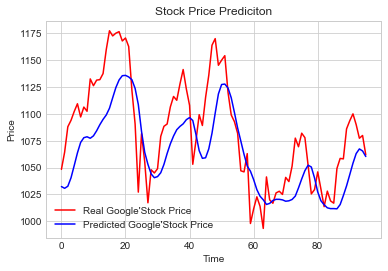

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline
# Plotting the real values against the predicted values
plt.plot(current_stock_price, color="Red", label="Real Google'Stock Price")
plt.plot(predicted_stock_price, color="Blue", label="Predicted Google'Stock Price")
plt.title('Stock Price Prediciton')
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [26]:
# One of the things of using the stock price, is that we might not care about the price of the stock
# but the direction it is predicted 

# However, the rmse can be useful
import math
from sklearn.metrics import mean_squared_error

rmse = math.sqrt(mean_squared_error(current_stock_price, predicted_stock_price))
rmse

35.375540015032634

In [27]:
current_stock_mean = np.mean(current_stock_price)

In [28]:
# Relative mean_squared error
rmse/current_stock_mean

0.0326504548298826

In [29]:
classifier = KerasClassifier(build_fn=build_classifier, batch_size=30, epochs=500)
parameters = {
    'batch_size': [20, 25, 30],
    'epochs': [100,300,500],
}
grid_search = GridSearchCV(param_grid=parameters,
                            scoring='neg_mean_squared_error',
                            cv=10,
                            n_jobs=-1)

grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_accuracies = grid_search.best_score_
print('{0} were the best parameters to use'.format(best_parameters))
print('{0} was the accuracies'.format(best_accuracies))

NameError: name 'KerasClassifier' is not defined